# COMP551: Project 4

In [0]:
import pandas as pd
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
transform = transforms.Compose([transforms.Resize(32,32),
                               transforms.ToTensor(),
                               #transforms.Lambda(lambda x: x.repeat(3,1,1)),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
training_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True,num_workers=2)
validloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False,num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


In [0]:
#*********************************************************************
# model part
import torchvision.models as models
# use pretrained model:
model = models.squeezenet1_0(pretrained = True)
#import OrderedDicted to corectly align the network layers


In [5]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [0]:
#import nn to modify features
from collections import OrderedDict
from torch import nn
#create classifier which fit our num of outputs

classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 10, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AvgPool2d(1)
)
#replace the model's classifier with this new classifier 
model.classifier = classifier
model.forward = lambda x: model.classifier(model.features(x)).view(x.size(0), 10)


In [7]:
print(model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): Fire(
      (squeeze): Conv2d(128, 32, kerne

In [0]:
#import optimizer:
from torch import optim
#define criteria and optimizer
# Note that other losses or optimizers can also be tried
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0003, momentum=0.9)

In [0]:
#train model
#define training function
def train (model, loader, criterion, gpu):
    model.train()
    current_loss = 0
    current_correct = 0
    for train, y_train in iter(loader):
        if gpu:
            train, y_train = train.to('cuda'), y_train.to('cuda')
        optimizer.zero_grad()
        output = model.forward(train)
        _, preds = torch.max(output,1)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        current_loss += loss.item()*train.size(0)
        current_correct += torch.sum(preds == y_train.data)
        #check if the training is correct: print(preds,y_train,current_correct,current_loss)
    epoch_loss = current_loss / len(loader)
    # devide 4 because we read 4 data everytime
    epoch_acc = current_correct.double() / len(loader)/100
        
    return epoch_loss, epoch_acc

In [0]:
#define validation function
def validation (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    #I added this
    pred=torch.zeros(len(loader))
    for valid, y_valid in iter(loader):
        if gpu:
            valid, y_valid = valid.to('cuda'), y_valid.to('cuda')
        output = model.forward(valid)
        _, preds = torch.max(output,1)
        valid_loss += criterion(output, y_valid).item()*valid.size(0)
        valid_correct += torch.sum(preds == y_valid.data)
    
    epoch_loss = valid_loss / len(loader)
    epoch_acc = valid_correct.double() / len(loader)/100
    
    return epoch_loss, epoch_acc

In [0]:
#define test function
def test (model, loader, criterion, gpu):
    model.eval()
    valid_loss = 0
    valid_correct = 0
    i=0
    pred=torch.zeros(len(loader))
    for test, y_train in iter(loader):
        if gpu:
            test = test.to('cuda')
        output = model.forward(test)
        _, preds = torch.max(output,1)
        pred[i]=preds
        i=i+1    
    return pred

In [12]:
# training
#send model to gpu. If not send it to GPU, delete next line.
model.to('cuda')
train_losses =[]
train_acc =[]
valid_losses=[]
valid_acc =[]
#Initialize training params  
#freeze gradient parameters in pretrained model
for param in model.parameters():
    param.require_grad = False
# define number of epochs
epochs = 16 
epoch = 0

for e in range(epochs):
    epoch +=1
    print(epoch)
#train:    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model,trainloader, criteria, 1)
        train_losses.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
    print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    
#Valid, Activate next code when validation result is needed:
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validation(model, validloader, criteria, 1)
        valid_losses.append(epoch_val_loss)
        valid_acc.append(epoch_val_acc)
    print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))

1
Epoch: 1 Train Loss : 233.2070  Train Accuracy: 0.1156
Epoch: 1 Validation Loss : 220.1811  Validation Accuracy 0.1754
2
Epoch: 2 Train Loss : 208.5169  Train Accuracy: 0.2635
Epoch: 2 Validation Loss : 179.5866  Validation Accuracy 0.4147
3
Epoch: 3 Train Loss : 158.9500  Train Accuracy: 0.4493
Epoch: 3 Validation Loss : 120.4747  Validation Accuracy 0.5681
4
Epoch: 4 Train Loss : 125.6574  Train Accuracy: 0.5565
Epoch: 4 Validation Loss : 104.0978  Validation Accuracy 0.6362
5
Epoch: 5 Train Loss : 111.8328  Train Accuracy: 0.6122
Epoch: 5 Validation Loss : 96.1874  Validation Accuracy 0.6688
6
Epoch: 6 Train Loss : 103.7934  Train Accuracy: 0.6448
Epoch: 6 Validation Loss : 91.5394  Validation Accuracy 0.6830
7
Epoch: 7 Train Loss : 98.1218  Train Accuracy: 0.6642
Epoch: 7 Validation Loss : 89.9857  Validation Accuracy 0.6844
8
Epoch: 8 Train Loss : 93.1434  Train Accuracy: 0.6815
Epoch: 8 Validation Loss : 86.0111  Validation Accuracy 0.7033
9
Epoch: 9 Train Loss : 89.8176  Train

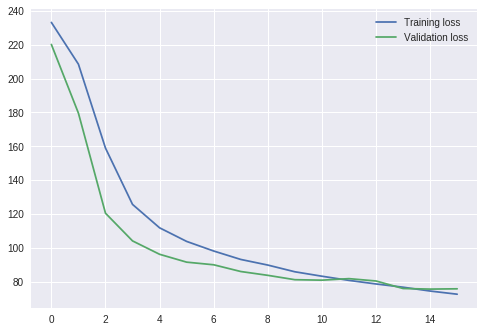

In [13]:
#Plot training and validation losses
import matplotlib.pyplot as plt
import numpy as np
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()

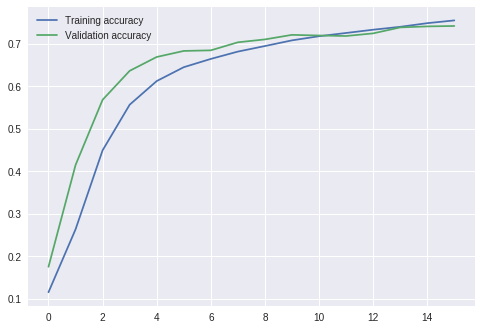

In [14]:
#Plot training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend()

In [15]:
# for variety, lets use altair to do the plot
import altair as alt

# create a pandas dataframe for the loss
df = pd.DataFrame({
    'epoch': range(1, len(train_losses) + 1),
    'train': train_losses,
    'valid': valid_losses
})

# unpivot to have cols [epoch, dataset, loss]
df = df.melt(id_vars=['epoch'],
             value_vars=['train', 'valid'],
             value_name='loss',
             var_name='Dataset')

# line plot with altair
alt.Chart(df).mark_line(point=True)\
    .encode(x='epoch', y='loss', color='Dataset')\
    .interactive()

Chart({
  data:     epoch Dataset        loss
  0       1   train  233.206973
  1       2   train  208.516879
  2       3   train  158.949961
  3       4   train  125.657400
  4       5   train  111.832845
  5       6   train  103.793375
  6       7   train   98.121805
  7       8   train   93.143384
  8       9   train   89.817558
  9      10   train   85.852480
  10     11   train   83.227571
  11     12   train   80.769225
  12     13   train   78.650491
  13     14   train   76.737610
  14     15   train   74.470842
  15     16   train   72.598634
  16      1   valid  220.181095
  17      2   valid  179.586605
  18      3   valid  120.474705
  19      4   valid  104.097757
  20      5   valid   96.187429
  21      6   valid   91.539437
  22      7   valid   89.985693
  23      8   valid   86.011056
  24      9   valid   83.749810
  25     10   valid   81.173940
  26     11   valid   80.893489
  27     12   valid   81.796267
  28     13   valid   80.412122
  29     14   valid   75.966634
  30     15   valid   75.618974
  31     16   valid   75.790832,
  encoding: EncodingWithFacet({
    color: Color({
      shorthand: 'Dataset'
    }),
    x: X({
      shorthand: 'epoch'
    }),
    y: Y({
      shorthand: 'loss'
    })
  }),
  mark: MarkDef({
    point: True,
    type: 'line'
  }),
  selection: SelectionMapping({
    selector001: SelectionDef({
      bind: 'scales',
      encodings: ['x', 'y'],
      type: 'interval'
    })
  })
})